# Weighted Average Download Speed at the Country level
Using Ookla's opensource dataset we calculate an average download speed weighted by population for each country quarterly from 2019 till 2nd quarter of 2025.

## Methodology
1. Filter Ookla's data by country. 
2. Aggregate Ookla's data to the desired zoom level. The zoom level should be smaller than 16 which is the level at which Ookla delivers their data. This step is optional if you want to work with 16 agregation level
3. Calculate an average speed for each tile by averaging the speeds at lower level tiles. Tiles with no speed as disregarded from the average
4. Aggregate Worldpop data to each tile, this results in an estimate of population at each tile.
5. Calculate an average download weighted by population as follows


$$
WeightedAvgSpeed_{tile_{i}} = \frac{Pop_{i} * AvgSpeed_{tile_{i}}}{\sum_{i=1}^{m}Pop_{i}} 
$$

Note: The data processing for this was done on the ookla-data-processing notebook.

In [1]:
import pandas as pd
import mercantile
from shapely.geometry import box
import geopandas as gpd
from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import rasterio
from rasterstats import zonal_stats
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import os
from shapely import Point

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
path_data = '/home/sol/gitrepo/MENA-FCV-economic-monitor/data/'
zoom = 12
net_type = 'fixed'

In [3]:
iso_codes = [
    "afg", "are", "bhr", "dji", "dza", "egy", "irn", "irq", "jor", "kwt",
    "lbn", "lby", "mar", "omn", "pak", "pse", "qat", "sau", "syr", "tun", "yem"]
iso_codes = [x.upper() for x in iso_codes]

In [4]:
countries_gdf = {}
for iso_code in iso_codes:
    gdf=gpd.read_file(f'../results/gdf_{iso_code}_with_variables.gpkg')
    gdf.set_index('index', inplace = True)
    countries_gdf[iso_code] = gdf

In [5]:
idx = []
for year in range(2019, 2026):
    for quarter in range(1, 5):
        if (quarter > 2) & (year == 2025):
            continue
        idx.append(f'{year}-{quarter}')
weighted_avg_download = pd.DataFrame(index = idx, columns = [])

In [6]:
for country, gdf in countries_gdf.items():
    for year in range(2019, 2026):
        for quarter in range(1, 5):
            if (quarter > 2) & (year == 2025):
                continue
            weighted_avg_download.loc[f'{year}-{quarter}', f'weighted_avg_download_{country}'] = sum((gdf[f'avg_download_{year}_{quarter}'].fillna(0))*gdf['population'])/(gdf['population'].sum())

In [7]:
weighted_avg_download.reset_index(inplace = True)
weighted_avg_download['index'] = weighted_avg_download['index'].apply(lambda x: str(x).replace('-', '-Q'))

## Results
In the following plot we can observe 3 groups of countries by their development of internet infrastructure:
- Hige level: ARE, KWT, QAT
- Mid level: BHR, JOR, OMN, PSE, SAU
- Low level: AFG, DJI, DZA, EGY, IRN, IRQ, LBN, LBY, MAR, PAK, SYR, TUN, YEM

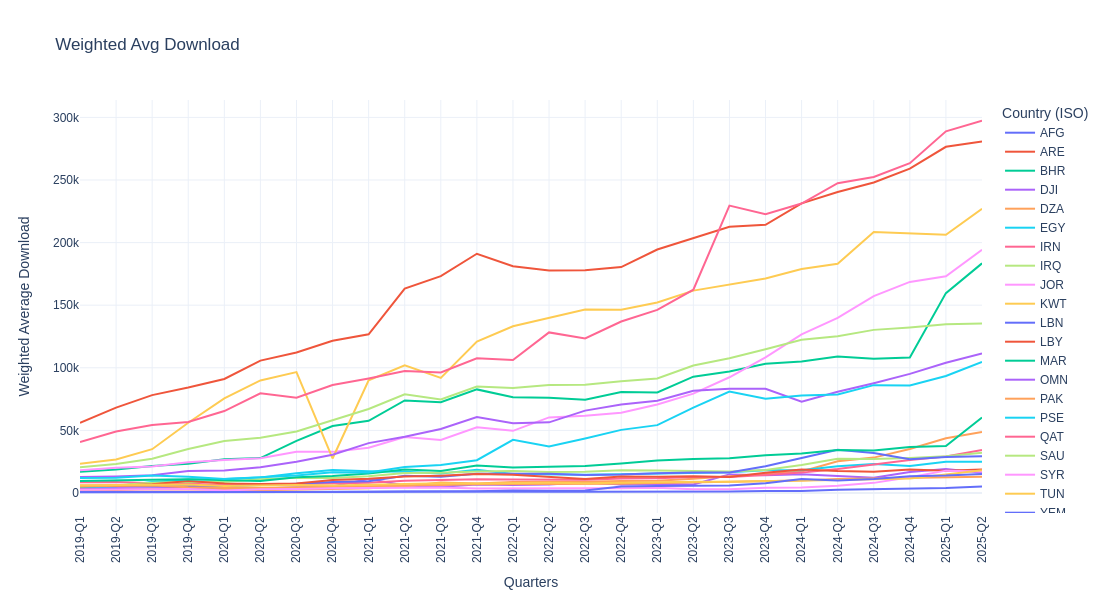

In [8]:
import numpy as np
import plotly.graph_objects as go

fig = go.Figure()

for iso_code in iso_codes:
    fig.add_trace(go.Scatter(
        x=weighted_avg_download['index'],
        y=weighted_avg_download[f'weighted_avg_download_{iso_code}'],
        mode='lines',
        name=iso_code,  # or use a mapping from iso_code to country name if needed
        # visible='legendonly'  # optional: initially hide this line
    ))

fig.update_layout(
    title='Weighted Avg Download',
    xaxis_title='Quarters',
    yaxis_title='Weighted Average Download',
    xaxis_tickangle=-90,
    legend_title='Country (ISO)',
    template='plotly_white', 
    height = 600
)

fig.show()

In order to follow the speed of development at each country, we also plotted the change in the Weighted Average Download Speed across the time. The change was calculated as follows


$$
Change = \frac{WADS_{t} - WADS_{t-1}}{WADS_{t-1}}
$$

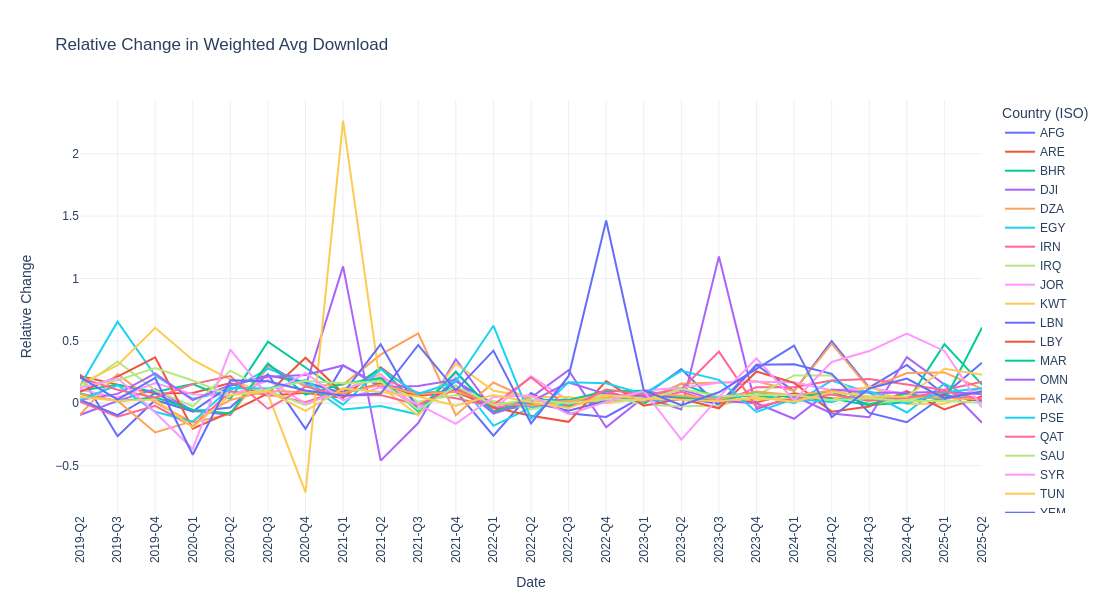

In [9]:
import numpy as np
import plotly.graph_objects as go

fig = go.Figure()

for iso_code in iso_codes:
    p2 = np.array(weighted_avg_download.iloc[1:][f'weighted_avg_download_{iso_code}'].tolist()) 
    p1 = np.array(weighted_avg_download.iloc[0:-1][f'weighted_avg_download_{iso_code}'].tolist())
    change = (p2 - p1) / p1
    x_vals = weighted_avg_download.iloc[1:]['index']
    fig.add_trace(go.Scatter(
        x=x_vals,
        y=change,
        mode='lines',
        name=iso_code,  # or use a mapping from iso_code to country name if needed
        # visible='legendonly'  # optional: initially hide this line
    ))

fig.update_layout(
    title='Relative Change in Weighted Avg Download',
    xaxis_title='Date',
    yaxis_title='Relative Change',
    xaxis_tickangle=-90,
    legend_title='Country (ISO)',
    template='plotly_white', 
    height = 600
)

fig.show()